# Transformer with Diffrence ID Dataset

In [1]:
from datetime import datetime
import json
import math
import os
import sys
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
try:
  from google.colab import drive
  IS_GOOGLE_COLAB = True
except ImportError:
  IS_GOOGLE_COLAB = False

if IS_GOOGLE_COLAB:
  mount_path = '/content/drive'
  base_folder = os.path.join(mount_path, "My Drive", "Data")
  data_folder = os.path.join(base_folder, "FX")
else:
  base_folder = 'L:/data'
  data_folder = os.path.join(base_folder, "fx", "OANDA-Japan MT5 Live")


device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
model_name = "ohlc_did_transformer"
model_version = "1"
batch_first = True

# parameters for dataset
ohlc_column = ['open','high','low','close']
time_column = "time"
file_name = "mt5_USDJPY_min30.csv"
file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)
clip_range = (-2, 2)

# training parameters
observation_length = 60
prediction_length = 10
lr = 0.0001
batch_size = 64

# model parameters
model_params = {
    "nhead": 4,
    "d_model": 120,
    "dim_feedforward": 10,
    "num_encoder_layers": 4,
    "num_decoder_layers": 4,
    # replace after dataset is defined
    "ohlc_size": None,
    "dropout": 0.1,
    "batch_first": batch_first,
}

In [4]:
import os
import shutil
import sys
import zipfile
import requests

def download_modlue_from_gh(repository, github_account='Naradice', branch='master', folder=None, module_path='/gdrive/My Drive/modules', **kwargs):
  if folder is None:
    folder = repository
  print(f"Downloading {repository} from {github_account}/{repository}/{branch}...")

  zip_url = f"https://github.com/{github_account}/{repository}/archive/refs/heads/{branch}.zip"
  response = requests.get(zip_url)
  if response.status_code == 200:
    with open("temp.zip", "wb") as f:
      f.write(response.content)
    with zipfile.ZipFile("temp.zip", "r") as zip_ref:
      zip_ref.extractall("temp_dir")

    if isinstance(folder, str):
      folders = [folder]
    else:
      folders = folder
    for folder in folders:    
      source_folder = f"temp_dir/{repository}-{branch}/{folder}"
      destination_folder = os.path.join(module_path, folder)
      print(f"Copying {source_folder} to {destination_folder}...")
      shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)
    os.remove("temp.zip")
    shutil.rmtree("temp_dir")
  else:
    print(f"filed to download {zip_url}: {response.status_code}, {response.text}")

In [5]:
if IS_GOOGLE_COLAB:
  drive.mount(mount_path)
  module_path = f"{mount_path}/My Drive/modules"
else:
  module_path = '../../modules'

if os.path.exists(module_path) is False:
  os.makedirs(module_path)

repositories = [
    {'repository': 'stocknet_study', 'branch': 'master', 'folder': ['Dataset', 'SN_Utils'], 'refresh': False},
    {'repository': 'finance_process', 'branch': 'master', 'folder': 'fprocess', 'refresh': False},
    {'repository': 'cloud_storage_handler', 'branch': 'main', 'folder': 'cloud_storage_handler', 'refresh': False},
]

destination = os.path.join(module_path, '__init__.py')
if os.path.exists(destination) is False:
  with open(destination, mode='w') as fp:
    fp.close()

for repo_kwargs in repositories:
  folders = repo_kwargs['folder']
  if isinstance(folders, str):
    folders = [folders]
  is_missing = False
  for folder in folders:
    destination = os.path.join(module_path, folder)
    if repo_kwargs['refresh'] or os.path.exists(destination) is False:
      is_missing = True
      break
  if is_missing:
    download_modlue_from_gh(**repo_kwargs, module_path=module_path)

In [ ]:
sys.path.append(module_path)

import cloud_storage_handler
import SN_Utils

In [7]:
# Initialize cloud storage handler if needed
from cloud_storage_handler import DropboxHandler


# storage_handler = DropboxHandler("nhjrq1cjpugk5hc", "http://localhost")
# storage_handler.authenticate()
# Otherwise, specify None
storage_handler = None

## Define Dataset

In [8]:
import random
from collections.abc import Iterable

import numpy as np
import torch


class CloseDiffIDDS:
    
    def __init__(self, df, ohlc_columns, volume_column=None, spread_column=None, observation_length=60, decimal_digits=3,
                device="cuda", future_step_size=1, seed=1017, is_training=True, batch_first=True, with_close=True, clip_range=None):
        self.seed(seed)
        self._BIAS = 10
        self.columns = ohlc_columns
        self.decimal_digits = decimal_digits
        self.__length_difference = 0
        self.__with_close = with_close
        self.__clip_range = clip_range
        self.__batch_first = batch_first
        self.__data = df.copy()
        self.ohlc_idf = self.__init_ohlc(df, ohlc_columns, decimal_digits=decimal_digits, with_close=with_close, clip_range=clip_range)
        
        self.observation_length = observation_length
        self.device = device
        self.future_step_size = future_step_size
        self.is_training = is_training
        self.__init_indicies(self.ohlc_idf)
    
    def __init_indicies(self, data, split_ratio=0.8):
        length = len(data) - self.observation_length - self.future_step_size
        if length < 0:
            raise Exception(f"date length {length} is less than observation_length {self.observation_length}")
        
        to_index = int(length * split_ratio)
        from_index = 0
        train_indices = list(range(from_index, to_index))
        self.train_indices = random.sample(train_indices, k=to_index - from_index)

        # Note: If unique value exits in validation data only, validation loss would be grater than expected
        from_index = int(length * split_ratio) + self.observation_length + self.future_step_size
        to_index = length
        eval_indices = list(range(from_index, to_index))
        self.eval_indices = random.sample(eval_indices, k=to_index - from_index)
        
        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.eval_indices
    
    def __init_ohlc(self, df, ohlc_columns, decimal_digits = 3, with_close=True, clip_range=None):
        if with_close:
            close_column = [ohlc_columns[3]]
            ohlc_cls_diff_df = df[ohlc_columns].iloc[1:] - df[close_column].iloc[:-1].values
            self.__length_difference += 1
        else:
            ohlc_cls_diff_df = df[ohlc_columns].diff().dropna()
            self.__length_difference += 1
        if clip_range is not None:
            ohlc_cls_diff_df = ohlc_cls_diff_df.clip(lower=clip_range[0], upper=clip_range[1])
        min_value = ohlc_cls_diff_df.min().min()
        min_value_abs = abs(min_value)

        self.__scale = 10 ** decimal_digits
        lower_value = math.ceil(min_value_abs) * self.__scale
        upper_value = math.ceil(ohlc_cls_diff_df.max().max()) * self.__scale
        self.ohlc_lower = lower_value
        id_df =  np.round(ohlc_cls_diff_df * self.__scale) + lower_value
        id_df = id_df.astype('int64')
        # add bias to avoid 0 value in the dataset
        self.ohlc_range_size = lower_value + upper_value + self._BIAS
        return id_df
    
    def revert_diff(self, prediction, index):
        periods = self.__length_difference
        org_indices = self.get_actual_index(index)
        if self.__with_close:
            if type(org_indices) is int:
                target_index = self.get_target_range(org_indices).start - periods
                last_close = self.__data[self.columns[3]].iloc[target_index].values
            else:
                target_index = [self.get_target_range(i).start - periods for i in org_indices]
                batch_size = len(org_indices)
                last_close = self.__data[self.columns[3]].iloc[target_index].values.reshape(batch_size, 1)
            return last_close + prediction
        else:
            if type(org_indices) is int:
                target_index = self.get_target_range(indeorg_indicesx).start - periods
                last_value = self.__data[self.columns].iloc[target_index].values
            else:
                target_index = [self.get_target_range(i).start - periods for i in org_indices]
                batch_size = len(org_indices)
                last_value = self.__data[self.columns].iloc[target_index].values.reshape(batch_size, len(self.columns))
            return prediction + last_value
    
    def revert_target(self, tgt_ohlc, indices):
        batch_size = len(indices)
        if self.__batch_first:
            tgt_ohlc = tgt_ohlc.transpose(0, 1)
        length = tgt_ohlc.size(0)
        tgt_batch_size = tgt_ohlc.size(1)
        if tgt_batch_size != batch_size:
            print(f"tgt_batch_size: {tgt_batch_size}, batch_size: {batch_size} with {self.__batch_first}")
            raise Exception("batch_size should be same as indices size")
        #revet id to difference: ohlc - last close
        tgt_values = tgt_ohlc.cpu().detach().numpy()
        scale = np.float64(1 / self.__scale)
        ohlc_diff = (tgt_values - self.ohlc_lower).astype(np.float64) * scale
        first_ohlc = self.revert_diff(ohlc_diff[0], indices)
        if self.__with_close:
            last_value = first_ohlc[:, -1:]
        else:
            last_value = first_ohlc
        revert_ohlc = first_ohlc.reshape(1, batch_size, 4)
        
        # last_observation + future_step_size
        for i in range(1, tgt_ohlc.size(0)):
            next_ohlc = ohlc_diff[i] + last_value
            if self.__with_close:
                last_value = next_ohlc[:, -1:]
            else:
                last_value = next_ohlc
            # print(revert_ohlc.shape, next_ohlc.shape)
            revert_ohlc = np.concatenate([revert_ohlc, next_ohlc.reshape(1, batch_size, 4)], axis=0)
        if self.__batch_first:
            ohlc_diff = ohlc_diff.reshape(batch_size, length, 4)
            revert_ohlc = revert_ohlc.reshape(batch_size, length, 4)
        return ohlc_diff, revert_ohlc

    def __get_data_set(self, idx):
        ohlc_ids = self.ohlc_idf.iloc[idx].values.tolist()
        return ohlc_ids
    
    def get_target_range(self, index):
        return slice(index + self.observation_length -1, index + self.observation_length + self.future_step_size)

    def _output_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = self.get_target_range(index)
            ohlc_ids = self.__get_data_set(idx)
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int64)
            
            return ohlc_ids
        elif type(batch_size) == slice:    
            ohlc_chunk_data = []            
            for index in self._indices[batch_size]:
                idx = self.get_target_range(index)
                ohlc_ids = self.__get_data_set(idx)
                ohlc_chunk_data.append(ohlc_ids)

            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int64)
            if self.__batch_first is False:
                ohlc_ids = ohlc_ids.transpose(0, 1)
            return ohlc_ids
    
    def get_observation_range(self, index):
        return slice(index, index + self.observation_length)
    
    def _input_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = self.get_observation_range(index)
            ohlc_ids = self.__get_data_set(idx)
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int64)

            return ohlc_ids
        elif type(batch_size) == slice:
            ohlc_chunk_data = []
            
            for index in self._indices[batch_size]:
                idx = self.get_observation_range(index)
                ohlc_ids = self.__get_data_set(idx)
                
                ohlc_chunk_data.append(ohlc_ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int64)
            if self.__batch_first is False:
                ohlc_ids = ohlc_ids.transpose(0, 1)
            return ohlc_ids
    
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, ndx):
        return self._input_func(ndx), self._output_func(ndx)
    
    def seed(self, seed=None):
        '''
        '''
        if seed is None:
            seed = 1192
        else:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
        self.seed_value = seed
            
    def eval(self):
        self._indices = self.eval_indices
        self.is_training = False
        
    def train(self):
        self._indices = self.train_indices
        self.is_training = False
    
    def get_index_range(self):
        return min(self._indices), max(self._indices)

    def get_date_range(self):
        min_index, max_index = self.get_index_range()
        return self.__data.index[min_index + self.__length_difference], self.__data.index[max_index + self.__length_difference]
    
    def get_actual_index(self, ndx):
        inputs = []
        if type(ndx) == slice:
            inputs = [index + self.__length_difference for index in self._indices[ndx]]
        elif isinstance(ndx, Iterable):
            for index in ndx:
                inputs.append(self._indices[index] + self.__length_difference)
        else:
            return self._indices[ndx] + self.__length_difference
        return inputs

## Define Model

input diff with positional encoding

output ohlc values with softmax

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.05, batch_first=True):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(-2)
        if batch_first:
            pe = pe.transpose(0, 1)
            self.forward = self.__fforward
        else:
            self.forward = self.__mforward
            
        self.register_buffer("pe", pe)

    def __mforward(self, src, tgt):
        src_pos = src.size(0)
        tgt_pos = src_pos + tgt.size(0) - 1
        return self.dropout(src + self.pe[:src_pos, :]), self.dropout(tgt + self.pe[src_pos-1:tgt_pos, :])
    
    def __fforward(self, src, tgt):
        src_pos = src.size(1)
        tgt_pos = src_pos + tgt.size(1) - 1
        return self.dropout(src + self.pe[:, :src_pos, :]), self.dropout(tgt + self.pe[:, src_pos-1:tgt_pos, :])

In [10]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        d_model: int, ohlc_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8, batch_first:bool = False
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        
        d_model = d_model + (d_model % 4)
        emb_d_model = int(d_model/4)
        self.ohlc_embedded_layer = torch.nn.Embedding(num_embeddings=ohlc_size, embedding_dim = emb_d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout, batch_first=batch_first)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=batch_first, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=batch_first, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.open_output = nn.Linear(d_model, ohlc_size)
        self.high_output = nn.Linear(d_model, ohlc_size)
        self.low_output = nn.Linear(d_model, ohlc_size)
        self.close_output = nn.Linear(d_model, ohlc_size)
        self.activation = nn.Softmax(dim=2)
        

    def forward(
        self, src_ohlc: Tensor, tgt_ohlc: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        src = self.ohlc_embedded_layer(src_ohlc)
        src = src.reshape(src.size(0), src.size(1), src.size(2)*src.size(3))
        
        tgt = self.ohlc_embedded_layer(tgt_ohlc)
        tgt = tgt.reshape(tgt.size(0), tgt.size(1), tgt.size(2)*tgt.size(3))
        
        src, tgt = self.positional_encoding(src, tgt)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        open_logits = self.activation(self.open_output(outs))
        high_logits = self.activation(self.high_output(outs))
        low_logits = self.activation(self.low_output(outs))
        close_logits = self.activation(self.close_output(outs))
        
        return open_logits, high_logits, low_logits, close_logits

In [11]:
def train(model, ds, optimizers, criterion, batch_size, batch_first):
    
    model = model.train()
    ds.train()
    losses = [0, 0, 0, 0]
    token_vocab_size = ds.ohlc_range_size
    
    end_index = len(ds) - batch_size
    if batch_first:
        get_tgt_input = lambda tgt: tgt[:, :-1]
        get_tgt_output = lambda tgt: tgt[:, 1:]
        get_length = lambda src: src.size(1)
    else:
        get_tgt_input = lambda tgt: tgt[:-1, :]
        get_tgt_output = lambda tgt: tgt[1:, :]
        get_length = lambda src: src.size(0)
    
    for index in tqdm(range(0, end_index, batch_size)):
        ohlc_src, ohlc_tgt = ds[index:index+batch_size]
        in_ohlc_tgt = get_tgt_input(ohlc_tgt)

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(get_length(ohlc_tgt)-1).to(device)
        logits_o, logits_h, logits_l, logits_c  = model(
            src_ohlc=ohlc_src, tgt_ohlc=in_ohlc_tgt, mask_tgt=mask_tgt
        )

        out_ohlc_tgt = get_tgt_output(ohlc_tgt)
        #print(logits_o.shape, out_ohlc_tgt.shape)
        out_o_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 0].to(dtype=torch.long), token_vocab_size).to(dtype=torch.float32)
        out_h_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 1].to(dtype=torch.long), token_vocab_size).to(dtype=torch.float32)
        out_l_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 2].to(dtype=torch.long), token_vocab_size).to(dtype=torch.float32)
        out_c_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 3].to(dtype=torch.long), token_vocab_size).to(dtype=torch.float32)
        
        for optimizer in optimizers:
            optimizer.zero_grad()
        
        o_loss = criterion(logits_o, out_o_tgt)
        h_loss = criterion(logits_h, out_h_tgt)
        l_loss = criterion(logits_l, out_l_tgt)
        c_loss = criterion(logits_c, out_c_tgt)
        loss = (o_loss + h_loss + l_loss + c_loss)/4
        
        loss.backward()
        for optimizer in optimizers:
            optimizer.step()
            
        losses[0] += o_loss.item()
        losses[1] += h_loss.item()
        losses[2] += l_loss.item()
        losses[3] += c_loss.item()
    
    losses = [loss/end_index for loss in losses]
    return losses

In [12]:
def evaluate(model, ds, criterion, batch_size, batch_first):
    
    model = model.eval()
    ds.eval()
    losses = [0, 0, 0, 0]
    end_index = len(ds) - batch_size
    token_vocab_size = ds.ohlc_range_size
    if batch_first:
        get_tgt_input = lambda tgt: tgt[:, :-1]
        get_tgt_output = lambda tgt: tgt[:, 1:]
        get_length = lambda src: src.size(1)
    else:
        get_tgt_input = lambda tgt: tgt[:-1, :]
        get_tgt_output = lambda tgt: tgt[1:, :]
        get_length = lambda src: src.size(0)

    for index in range(0, end_index, batch_size):
        ohlc_src, ohlc_tgt = ds[index:index+batch_size]        
        in_ohlc_tgt = get_tgt_input(ohlc_tgt)

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(get_length(ohlc_tgt)-1).to(device)
        logits_o, logits_h, logits_l, logits_c  = model(
            src_ohlc=ohlc_src, tgt_ohlc=in_ohlc_tgt, mask_tgt=mask_tgt
        )

        out_ohlc_tgt = get_tgt_output(ohlc_tgt)
        #print(logits_o.shape, out_ohlc_tgt.shape)
        out_o_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 0].to(dtype=torch.long), token_vocab_size).to(dtype=torch.float32)
        out_h_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 1].to(dtype=torch.long), token_vocab_size).to(dtype=torch.float32)
        out_l_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 2].to(dtype=torch.long), token_vocab_size).to(dtype=torch.float32)
        out_c_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 3].to(dtype=torch.long), token_vocab_size).to(dtype=torch.float32)
        
        o_loss = criterion(logits_o, out_o_tgt)
        h_loss = criterion(logits_h, out_h_tgt)
        l_loss = criterion(logits_l, out_l_tgt)
        c_loss = criterion(logits_c, out_c_tgt)
        
        losses[0] += o_loss.item()
        losses[1] += h_loss.item()
        losses[2] += l_loss.item()
        losses[3] += c_loss.item()
    
    losses = [loss/end_index for loss in losses]
    return losses

## Training

In [13]:
df = pd.read_csv(file_path, parse_dates=[time_column], index_col=0)
ds = CloseDiffIDDS(df, ohlc_column, observation_length=observation_length,
                device=device, future_step_size=prediction_length, seed=1017, batch_first=batch_first,
                is_training=True, with_close=False, clip_range=clip_range)
model_params['ohlc_size'] = ds.ohlc_range_size

In [14]:
model = Seq2SeqTransformer(
    **model_params
)

params_num = 0
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    if p.requires_grad:
        params_num += p.numel()
print(f"params: {params_num}")

model = model.to(device)
criterion = nn.CrossEntropyLoss()

params: 2783140


In [15]:
logger = SN_Utils.Logger(
    version=model_version,
    model_name=model_name,
    storage_handler=storage_handler
)

In [16]:
start_index, end_index = ds.get_date_range()
params = {"processes": None,
          "source": {
              "path": file_path,
              "start": start_index.isoformat(),
              "end": end_index.isoformat(),
              "length": len(ds)
          },
          "features": ohlc_column,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          **model_params,
          "params_num": params_num,
          # format version
          "version": 2
}

logger.save_params(params, model_name, model_version)

print("training log will be saved on ", logger.log_file_path)

training log will be saved on  ./ohlc_did_transformer\ohlc_did_transformer_v1.csv


In [18]:
def get_parameters(model, outlayer_name=None, limit_outlayer=True):
    parameters = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            if outlayer_name is None:
                parameters.append(param)
            elif "output" in name:
                if outlayer_name in name:
                    parameters.append(param)
    return parameters

In [19]:
optimizer_common = torch.optim.AdamW(get_parameters(model), lr=lr)
scheduler_common = torch.optim.lr_scheduler.StepLR(optimizer_common, 1.0, gamma = 0.1)
optimizer_o = torch.optim.AdamW(get_parameters(model, "open_output"), lr=lr)
scheduler_o = torch.optim.lr_scheduler.StepLR(optimizer_o, 1.0, gamma = 0.1)
optimizer_h = torch.optim.AdamW(get_parameters(model, "high_output"), lr=lr)
scheduler_h = torch.optim.lr_scheduler.StepLR(optimizer_h, 1.0, gamma = 0.1)
optimizer_l = torch.optim.AdamW(get_parameters(model, "low_output"), lr=lr)
scheduler_l = torch.optim.lr_scheduler.StepLR(optimizer_l, 1.0, gamma = 0.1)
optimizer_c = torch.optim.AdamW(get_parameters(model, "close_output"), lr=lr)
scheduler_c = torch.optim.lr_scheduler.StepLR(optimizer_c, 1.0, gamma = 0.1)

In [20]:
epoch = 5
model.train()
ds.train()
best_loss = float('Inf')
best_model = None
best_losses = [float('Inf') for i in range(6)]
patience = 3
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizers=[optimizer_o, optimizer_h, optimizer_l, optimizer_c],
        criterion=criterion, batch_size=batch_size, batch_first=batch_first
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size, batch_first=batch_first
    )
    
    mean_loss_train = np.mean(loss_train)
    mean_loss_valid = np.mean(loss_valid)
    print(f'{loop}/{epoch} {str(int(math.floor(elapsed_time / 60))) + "m" if math.floor(elapsed_time / 60) > 0 else ""}{elapsed_time % 60}s count: {counter}, \
        {mean_loss_train}, {mean_loss_valid}\
        {"**" if best_loss > mean_loss_valid else ""}')
    print(f'train loss: {loss_train}')
    print(f'valid loss: {loss_valid}')
    logger.add_training_log(mean_loss_train, mean_loss_valid, log_entry=[*loss_train, *loss_valid, elapsed_time])
    
    if best_loss > mean_loss_valid:
        best_loss = mean_loss_valid
        best_model = model
        counter = 0
        logger.save_model(best_model)
    else:
        counter += 1
    for index, scheduler in enumerate([scheduler_o, scheduler_h, scheduler_l, scheduler_c]):
        if best_losses[index] < loss_valid[index]:
            scheduler.step()
        
    if counter > patience:
        break

100%|██████████| 1258/1258 [04:53<00:00,  4.29it/s]


1/5 4m53.072019815444946s count: 0,         8.978399483373684e-05, 8.988196074878408e-05        **
train loss: [8.97839968001581e-05, 8.978399418983878e-05, 8.978399472810862e-05, 8.978399361684186e-05]
valid loss: [8.988196144741573e-05, 8.988196095837357e-05, 8.988195991042609e-05, 8.988196067892091e-05]


100%|██████████| 1258/1258 [04:49<00:00,  4.35it/s]


2/5 4m49.16527318954468s count: 0,         8.97839936153949e-05, 8.988196083611304e-05        
train loss: [8.978399316538974e-05, 8.978399509274302e-05, 8.978399244769662e-05, 8.97839937557502e-05]
valid loss: [8.988196137755257e-05, 8.98819609816613e-05, 8.98819602364542e-05, 8.988196074878408e-05]


100%|██████████| 1258/1258 [04:45<00:00,  4.41it/s]


3/5 4m45.35536503791809s count: 1,         8.97839940711879e-05, 8.988196069056477e-05        **
train loss: [8.978399461235167e-05, 8.978399409144537e-05, 8.978399398147626e-05, 8.978399359947832e-05]
valid loss: [8.988196121453851e-05, 8.988196074878408e-05, 8.988196000357697e-05, 8.988196079535952e-05]


100%|██████████| 1258/1258 [09:02<00:00,  2.32it/s]


4/5 9m2.5548806190490723s count: 0,         8.978399427231562e-05, 8.988196079535952e-05        
train loss: [8.978399370944743e-05, 8.978399434032283e-05, 8.978399469916938e-05, 8.978399434032283e-05]
valid loss: [8.988196142412802e-05, 8.988196084193496e-05, 8.988196007344014e-05, 8.988196084193496e-05]


100%|██████████| 1258/1258 [04:31<00:00,  4.63it/s]


5/5 4m53.272568225860596s count: 1,         8.97839937600911e-05, 8.988196067892092e-05        **
train loss: [8.97839946644423e-05, 8.978399405671828e-05, 8.978399378468945e-05, 8.978399253451434e-05]
valid loss: [8.988196107481218e-05, 8.988196072549635e-05, 8.988196000357697e-05, 8.988196091179813e-05]


## Evaluation

In [52]:
# Define prediction functions

def calculate_joint(tensor_a, tensor_b, beam_width=10):
    joint_array = []
    for i in range(beam_width):
        joint_array.append(torch.mul(tensor_a[:, :, i:i+1], tensor_b))
    joint_tensor = torch.concat(joint_array, dim=2)
    return joint_tensor

def next_preds_beam(scores_array, indices_array, batch_size=16, beam_width=10, batch_first=False):
    beam_batch = batch_size * beam_width
    joint_indices_array = []
    joint_score = scores_array[0]
    if batch_first:
        target_shape = (beam_batch, 1, 1)
    else:
        target_shape = (1, beam_batch, 1)

    for logits in scores_array[1:]:
        joint_score = calculate_joint(joint_score, logits, beam_width=beam_width)
        joint_score, joint_indices = torch.topk(joint_score, k=beam_width, dim=-1)
        joint_indices_array.append(joint_indices)
    
    next_preds_array = []
    indices_array.reverse()
    for index, indices in enumerate(indices_array[:-1]):
        joint_indices = joint_indices_array[index]
        target_indices = torch.remainder(joint_indices, beam_width)
        next_preds = indices.gather(dim=-1, index=target_indices)
        next_preds_array.append(next_preds.mT.reshape(*target_shape))
        
    target_indices = joint_indices // beam_width
    next_preds = indices_array[-1].gather(dim=-1, index=target_indices)
    next_preds_array.append(next_preds.mT.reshape(*target_shape))
    next_preds_array.reverse()
    
    next_ohlc_preds = torch.concat(next_preds_array, dim=-1)
    
    return next_ohlc_preds

def joint_beam_search(model, input_data, beam_width, max_len, max_range=None, batch_first=False):
    if max_range is None:
        max_id_index = None
    else:
        max_id_index = max_range - 1

    ohlc_src = input_data
    if batch_first:
        batch_size = ohlc_src.shape[0]
        preds_ohlc = ohlc_src[:, -1:]
        length_dim = 1
        get_last_tensor = lambda x: x[:, -1:]
    else:
        batch_size = ohlc_src.shape[1]
        preds_ohlc = ohlc_src[-1:]
        length_dim = 0
        get_last_tensor = lambda x: x[-1:]
    
    logits_o, logits_h,logits_l,logits_c  = model(
        src_ohlc=ohlc_src, tgt_ohlc=preds_ohlc,
        mask_tgt=None, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
        memory_key_padding_mask=None
    )
    
    scores_o, indices = torch.topk(logits_o, k=beam_width, dim=-1)
    scores_h, indices_h = torch.topk(logits_h, k=beam_width, dim=-1)
    scores_l, indices_l = torch.topk(logits_l, k=beam_width, dim=-1)
    scores_c, indices_c = torch.topk(logits_c, k=beam_width, dim=-1)
    
    next_ohlc_preds = next_preds_beam(
        scores_array=[scores_o, scores_h, scores_l, scores_c],
        indices_array=[indices, indices_h, indices_l, indices_c],
        batch_size=batch_size, beam_width=beam_width, batch_first=batch_first
    )
    
    if batch_first:
        preds_ohlc = preds_ohlc.repeat(beam_width, 1, 1)
        ohlc_src = ohlc_src.repeat(beam_width, 1, 1)
    else:
        preds_ohlc = preds_ohlc.repeat(1, beam_width, 1)
        ohlc_src = ohlc_src.repeat(1, beam_width, 1)
    
    for t in range(1, max_len):
        preds_ohlc = torch.concat([preds_ohlc, next_ohlc_preds], dim=length_dim)

        logits_o, logits_h, logits_l,logits_c = model(
            src_ohlc=ohlc_src, tgt_ohlc=preds_ohlc, mask_tgt=None, 
            mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        
        beamed_feature_size = logits_o.shape[2]*beam_width
        if batch_first:
            target_shape = (batch_size, 1, beamed_feature_size)
        else:   
            target_shape = (1, batch_size, beamed_feature_size)

        scores_o, indices_o = torch.topk(get_last_tensor(logits_o).reshape(*target_shape), k=beam_width, dim=-1)
        indices_o = torch.remainder(indices_o, beamed_feature_size)
        scores_h, indices_h = torch.topk(get_last_tensor(logits_h).reshape(*target_shape), k=beam_width, dim=-1)
        indices_h = torch.remainder(indices_h, beamed_feature_size)
        scores_l, indices_l = torch.topk(get_last_tensor(logits_l).reshape(*target_shape), k=beam_width, dim=-1)
        indices_l = torch.remainder(indices_l, beamed_feature_size)
        scores_c, indices_c = torch.topk(get_last_tensor(logits_c).reshape(*target_shape), k=beam_width, dim=-1)
        indices_c = torch.remainder(indices_c, beamed_feature_size)
        
        next_ohlc_preds = next_preds_beam(
            scores_array=[scores_o, scores_h, scores_l, scores_c],
            indices_array=[indices, indices_h, indices_l, indices_c],
            batch_size=batch_size, beam_width=beam_width, batch_first=batch_first
        )

        if max_id_index is not None:
            next_ohlc_preds = torch.clamp(next_ohlc_preds, min=0, max=max_id_index)
    
    preds_ohlc = torch.concat([preds_ohlc, next_ohlc_preds], dim=length_dim)
    return preds_ohlc

### Check revert and prediction process

In [40]:
sample_index = 0
ds.eval()

input_data, tgt_data = ds[sample_index:sample_index+2]

In [24]:
# tgt_length, batch_size, feature_size = tgt_data.shape
if batch_first:
    print(tgt_data[0, :])
else:
    print(tgt_data[:, 0])

tensor([[1979, 1973, 1821, 1825],
        [1828, 1989, 2000, 2162],
        [2170, 2004, 2166, 1995],
        [1983, 2027, 1999, 2041],
        [2041, 2017, 2031, 1999],
        [2000, 2027, 2008, 2035],
        [2035, 2019, 2002, 1989],
        [1989, 2054, 2011, 2084],
        [2084, 2026, 2053, 1988],
        [1988, 1976, 1975, 1946],
        [1946, 1920, 1946, 1981]])


In [25]:
# check sample_tgt_indices are valid
sample_tgt_indices = ds.get_target_range(ds._indices[sample_index])
id_df = ds.ohlc_idf.iloc[sample_tgt_indices]
id_df

,open,high,low,close
time,,,,
2021-07-08 23:30:00,1979,1973,1821,1825
2021-07-09 00:00:00,1828,1989,2000,2162
2021-07-09 00:30:00,2170,2004,2166,1995
2021-07-09 01:00:00,1983,2027,1999,2041
2021-07-09 01:30:00,2041,2017,2031,1999
2021-07-09 02:00:00,2000,2027,2008,2035
2021-07-09 02:30:00,2035,2019,2002,1989
2021-07-09 03:00:00,1989,2054,2011,2084
2021-07-09 03:30:00,2084,2026,2053,1988


In [26]:
# check original values and indices
index_org = ds.get_actual_index(sample_index)
sample_tgt_indices_org = ds.get_target_range(index_org)
tgt_org = df[ohlc_column].iloc[sample_tgt_indices_org]

# print original values
print("Original values: Target")
print(tgt_org)

Original values: Target
                        open     high      low    close
time                                                   
2021-07-08 23:30:00  109.756  109.761  109.570  109.581
2021-07-09 00:00:00  109.584  109.750  109.570  109.743
2021-07-09 00:30:00  109.754  109.754  109.736  109.738
2021-07-09 01:00:00  109.737  109.781  109.735  109.779
2021-07-09 01:30:00  109.778  109.798  109.766  109.778
2021-07-09 02:00:00  109.778  109.825  109.774  109.813
2021-07-09 02:30:00  109.813  109.844  109.776  109.802
2021-07-09 03:00:00  109.802  109.898  109.787  109.886
2021-07-09 03:30:00  109.886  109.924  109.840  109.874
2021-07-09 04:00:00  109.874  109.900  109.815  109.820
2021-07-09 04:30:00  109.820  109.820  109.761  109.801


In [27]:
# caliculate revert values with dataset output
if batch_first:
    id_to_diff_tgt, reverted_tgt = ds.revert_target(tgt_data[sample_index:sample_index+1], [sample_index])
else:
    id_to_diff_tgt, reverted_tgt = ds.revert_target(tgt_data[:, sample_index:sample_index+1, :], [sample_index])

In [28]:
# check if id process have errors
org_diff_tgt = df[ohlc_column].diff().iloc[sample_tgt_indices_org].values.reshape(*id_to_diff_tgt.shape)
np.allclose(id_to_diff_tgt, org_diff_tgt, atol=1e-10)

True

In [29]:
# check if revert process have errors
org_tgt = df[ohlc_column].iloc[sample_tgt_indices_org].values.reshape(*reverted_tgt.shape)
np.allclose(reverted_tgt, org_tgt, atol=1e-10)

True

In [53]:
# caliculate predictions with model
model = model.eval()
preds_ohlc = joint_beam_search(model, input_data, beam_width=3, max_len=10, max_range=ds.ohlc_range_size, batch_first=batch_first)

In [54]:
# show first candidate
if batch_first:
    print(preds_ohlc[0, 1:])
else:
    print(preds_ohlc[1:, 0])

tensor([[2396, 3968, 3511, 3522],
        [2396, 4009, 3511, 4009],
        [2396, 4009, 4009, 1811],
        [2396, 4009, 4009, 4009],
        [2396, 4009, 4009, 4009],
        [2396, 4009, 4009, 4009],
        [2396, 4009, 4009, 4009],
        [2396, 4009, 3511, 4009],
        [2396, 4009, 4009, 4009],
        [2396, 4009, 4009, 4009]])


In [59]:
# revert predictions to original values
if batch_first:
    preds_diff, preds_rev = ds.revert_target(preds_ohlc[0:1], [sample_index])
    print(preds_diff[0])
else:
    preds_diff, preds_rev = ds.revert_target(preds_ohlc[:, 0:1], [sample_index])
    print(preds_diff[:, 0])

[[-0.021 -0.027 -0.179 -0.175]
 [ 0.396  1.968  1.511  1.522]
 [ 0.396  2.009  1.511  2.009]
 [ 0.396  2.009  2.009 -0.189]
 [ 0.396  2.009  2.009  2.009]
 [ 0.396  2.009  2.009  2.009]
 [ 0.396  2.009  2.009  2.009]
 [ 0.396  2.009  2.009  2.009]
 [ 0.396  2.009  1.511  2.009]
 [ 0.396  2.009  2.009  2.009]
 [ 0.396  2.009  2.009  2.009]]


## Evaluate with validation data

In [61]:
ds.eval()
model = model.eval()

ans_ohlc = None
pre_ohlc = None
pre_ohlc_diff = None
if batch_first:
    batch_dim = 0
else:
    batch_dim = 1

start_time = time.time()
for index in range(0, len(ds), batch_size):
    if len(ds) - index < batch_size:
        ndx = slice(index, len(ds))
        indices = [i for i in range(index, len(ds))]
        B = len(ds) - index
    else:
        ndx = slice(index, index+batch_size)
        indices = [i for i in range(index, index+batch_size)]
        B = batch_size
    val_inp, val_ans = ds[ndx]
            
    preds_ohlc_candidates = joint_beam_search(model, val_inp, beam_width=3, max_len=10, max_range=ds.ohlc_range_size, batch_first=batch_first)
    # batch is repeated by beam_width. Retrieve only the first beam_width
    if batch_first:
        first_pre_ohlc = preds_ohlc_candidates[:B]
    else:
        first_pre_ohlc = preds_ohlc_candidates[:, :B, :]
    pre_ohlc_diff_item, pre_ohlc_item = ds.revert_target(first_pre_ohlc, indices)

    if pre_ohlc is None:
        pre_ohlc = pre_ohlc_item
        pre_ohlc_diff = pre_ohlc_diff_item
    else:
        pre_ohlc = np.concatenate([pre_ohlc, pre_ohlc_item], axis=batch_dim)
        pre_ohlc_diff = np.concatenate([pre_ohlc_diff, pre_ohlc_diff_item], axis=batch_dim)

    ans_ohlc_diff_item, ans_ohlc_item = ds.revert_target(val_ans, indices)
    if ans_ohlc is None:
        ans_ohlc = ans_ohlc_item
    else:
        ans_ohlc = np.concatenate([ans_ohlc, ans_ohlc_item], axis=batch_dim)

In [ ]:
if batch_first:
    diff_array = pre_ohlc[:, 1:] - ans_ohlc[:, 1:]
    len_dim = 1
else:
    diff_array = pre_ohlc[1:] - ans_ohlc[1:]
    len_dim = 0
    
columns = ["open", "high", "low", "close"]
mean_df = pd.DataFrame(np.mean(diff_array, axis=batch_dim), columns=columns)
var_df = pd.DataFrame(np.var(diff_array, axis=batch_dim), columns=columns)

print(mean_df)
print(var_df)

       open      high       low     close
0  0.725369  9.071023  8.751318  6.282665
1  0.735936  9.107140  8.774317  6.322603
2  0.723782  9.124361  8.806652  6.335778
3  0.737456  9.164540  8.830896  6.371984
4  0.721006  9.186484  8.864251  6.388500
5  0.743035  9.222862  8.891303  6.407427
6  0.718441  9.244182  8.916960  6.435082
7  0.747480  9.279058  8.947571  6.439263
8  0.719598  9.300772  8.968117  6.466228
9  0.748223  9.327359  9.003957  6.491550
       open       high        low      close
0  2.279502  34.206604  34.391614  26.209035
1  2.251210  34.849898  34.849848  26.773290
2  2.294719  34.526666  34.659537  26.524433
3  2.275747  35.012370  35.031732  26.952440
4  2.307789  34.607805  34.755937  26.831927
5  2.276185  34.923269  35.097529  27.007625
6  2.315404  34.479098  34.692491  26.659408
7  2.287625  34.594517  34.908908  26.703833
8  2.313460  34.277215  34.457446  26.748500
9  2.285199  34.209678  34.561176  26.639096


[]

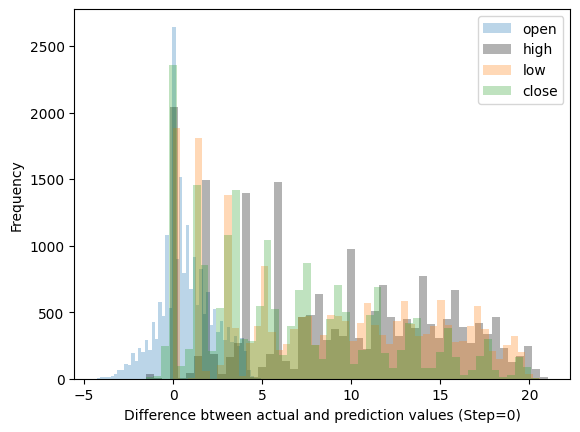

In [64]:
import matplotlib.pyplot as plt

if batch_first:
    get_feature_by_step = lambda array, step, feature_dim: array[:,step, feature_dim]
else:
    get_feature_by_step = lambda array, step, feature_dim: array[step, :, feature_dim]
    
step=0
plt.hist(get_feature_by_step(diff_array, step, 0), bins=50, alpha=0.3)
plt.hist(get_feature_by_step(diff_array, step, 1), bins=50, alpha=0.3, color="black")
plt.hist(get_feature_by_step(diff_array, step, 2), bins=50, alpha=0.3)
plt.hist(get_feature_by_step(diff_array, step, 3), bins=50, alpha=0.3)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['open', 'high', "low", "close"])
plt.plot()

[]

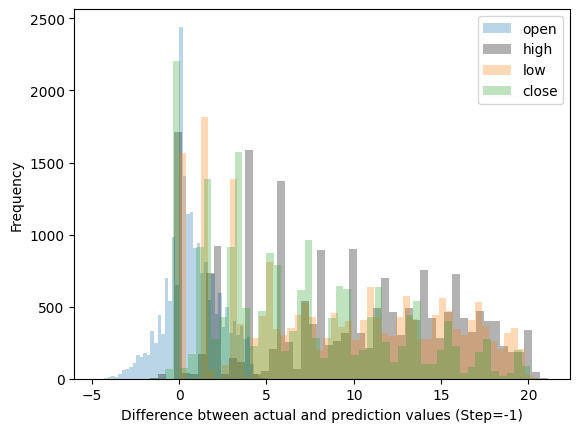

In [65]:
step=-1
plt.hist(get_feature_by_step(diff_array, step, 0), bins=50, alpha=0.3)
plt.hist(get_feature_by_step(diff_array, step, 1), bins=50, alpha=0.3, color="black")
plt.hist(get_feature_by_step(diff_array, step, 2), bins=50, alpha=0.3)
plt.hist(get_feature_by_step(diff_array, step, 3), bins=50, alpha=0.3)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['open', 'high', "low", "close"])
plt.plot()

[]

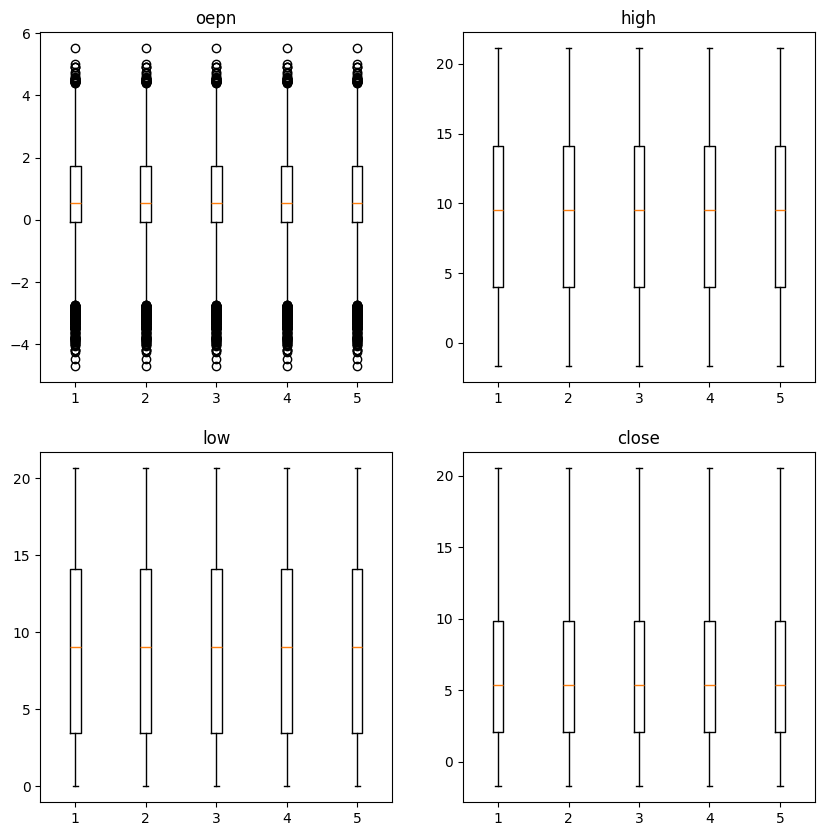

In [66]:
quant_1_df = pd.DataFrame(np.quantile(diff_array, 0.25, axis=batch_dim), columns=columns)
quant_2_df = pd.DataFrame(np.quantile(diff_array, 0.5, axis=batch_dim), columns=columns)
quant_3_df = pd.DataFrame(np.quantile(diff_array, 0.75, axis=batch_dim), columns=columns)
min_df = pd.DataFrame(np.min(diff_array, axis=batch_dim), columns=columns)
max_df = pd.DataFrame(np.max(diff_array, axis=batch_dim), columns=columns)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# plot quantile values with prediction steps
for index in range(0, 5):
  axs[0,0].boxplot(get_feature_by_step(diff_array, step, 0), positions=[index+1])
  axs[0,1].boxplot(get_feature_by_step(diff_array, step, 1), positions=[index+1])
  axs[1,0].boxplot(get_feature_by_step(diff_array, step, 2), positions=[index+1])
  axs[1,1].boxplot(get_feature_by_step(diff_array, step, 3), positions=[index+1])

axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')
plt.plot()

[]

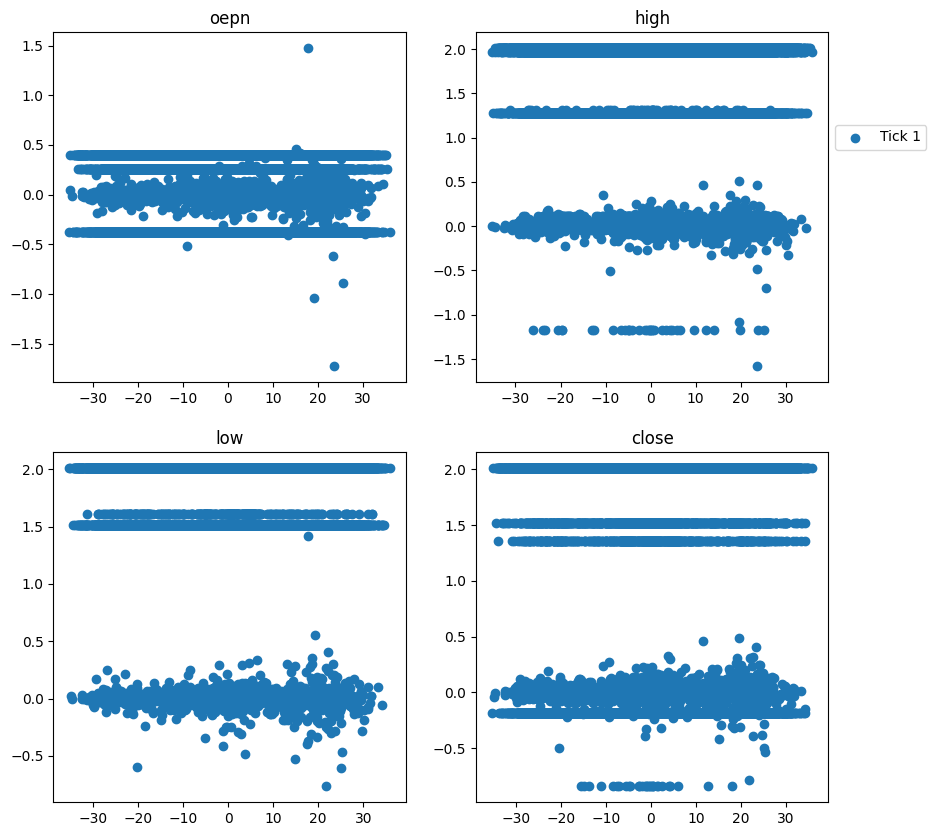

In [68]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

ans_ohlc_diff = np.diff(ans_ohlc, axis=len_dim)

axs[0,0].scatter(get_feature_by_step(ans_ohlc_diff, 0, 0), get_feature_by_step(pre_ohlc_diff, 1, 0), label=f'Tick {1}')
axs[0,1].scatter(get_feature_by_step(ans_ohlc_diff, 0, 1), get_feature_by_step(pre_ohlc_diff, 1, 1), label=f'Tick {1}')
axs[1,0].scatter(get_feature_by_step(ans_ohlc_diff, 0, 2), get_feature_by_step(pre_ohlc_diff, 1, 2), label=f'Tick {1}')
axs[1,1].scatter(get_feature_by_step(ans_ohlc_diff, 0, 3), get_feature_by_step(pre_ohlc_diff, 1, 3), label=f'Tick {1}')
axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')

axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.plot()

[]

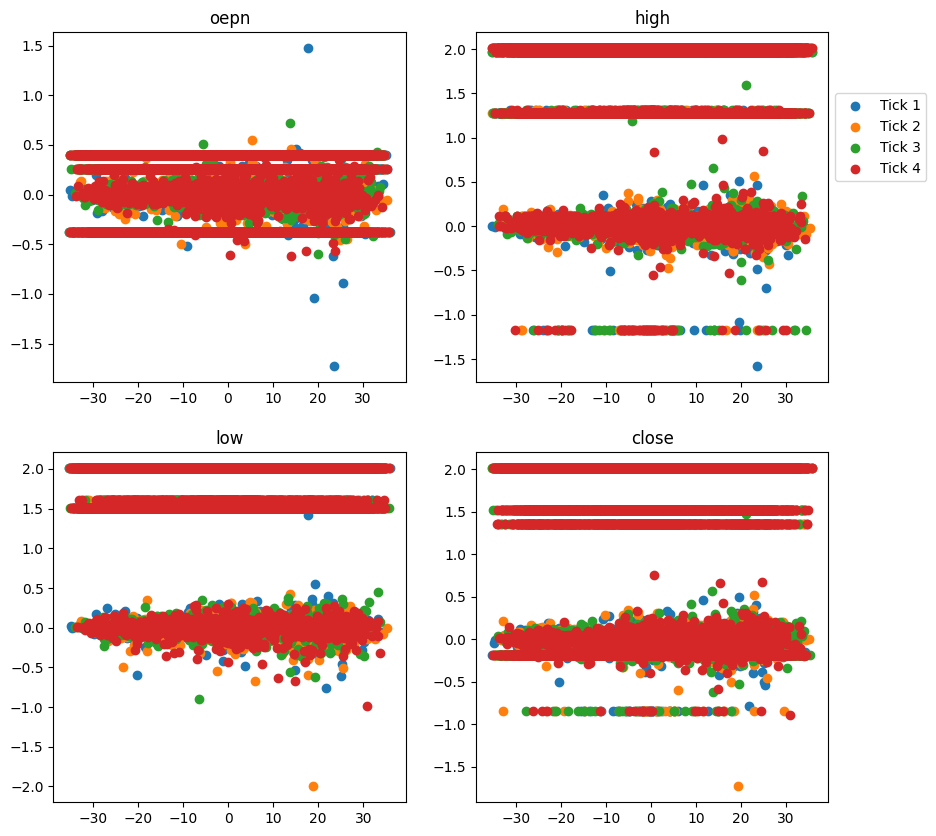

In [69]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for step in range(1, 5):
  axs[0,0].scatter(get_feature_by_step(ans_ohlc_diff, step-1, 0), get_feature_by_step(pre_ohlc_diff, step, 0), label=f'Tick {step}')
  axs[0,1].scatter(get_feature_by_step(ans_ohlc_diff, step-1, 1), get_feature_by_step(pre_ohlc_diff, step, 1), label=f'Tick {step}')
  axs[1,0].scatter(get_feature_by_step(ans_ohlc_diff, step-1, 2), get_feature_by_step(pre_ohlc_diff, step, 2), label=f'Tick {step}')
  axs[1,1].scatter(get_feature_by_step(ans_ohlc_diff, step-1, 3), get_feature_by_step(pre_ohlc_diff, step, 3), label=f'Tick {step}')
axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')
axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.plot()

In [71]:
if batch_first:
    diff_array_org = pre_ohlc_diff[:, 1:] - ans_ohlc_diff
else:
    diff_array_org = pre_ohlc_diff[1:] - ans_ohlc_diff
mean_org_df = pd.DataFrame(np.mean(diff_array_org, axis=batch_dim), columns=["open", "high", "low", "close"])
var_org_df = pd.DataFrame(np.var(diff_array_org, axis=batch_dim), columns=["open", "high", "low", "close"])

print(mean_org_df)
print(var_org_df)

       open      high       low     close
0  0.132771  1.657888  1.658482  1.248534
1  0.131550  1.654387  1.653757  1.249888
2  0.132233  1.652434  1.656188  1.253202
3  0.129674  1.654058  1.656452  1.264678
4  0.130799  1.653030  1.658727  1.249336
5  0.132839  1.653491  1.659578  1.257510
6  0.126848  1.655359  1.659975  1.267124
7  0.133891  1.665953  1.663197  1.260117
8  0.131534  1.682052  1.681816  1.286841
9  0.135563  1.687575  1.685956  1.289368
         open        high         low       close
0  179.053959  180.147133  178.540373  180.276749
1  178.950452  179.803982  178.115151  179.811846
2  178.971662  180.132102  178.472003  180.214068
3  178.914586  179.879945  178.255875  180.020585
4  178.985804  180.065986  178.583343  180.009201
5  178.931567  179.777499  178.096641  180.280618
6  179.059125  180.177643  178.527127  180.076934
7  178.963635  180.085778  178.349886  180.378360
8  179.018363  180.070329  178.545291  180.026907
9  178.939099  179.779324  178.108698 

[]

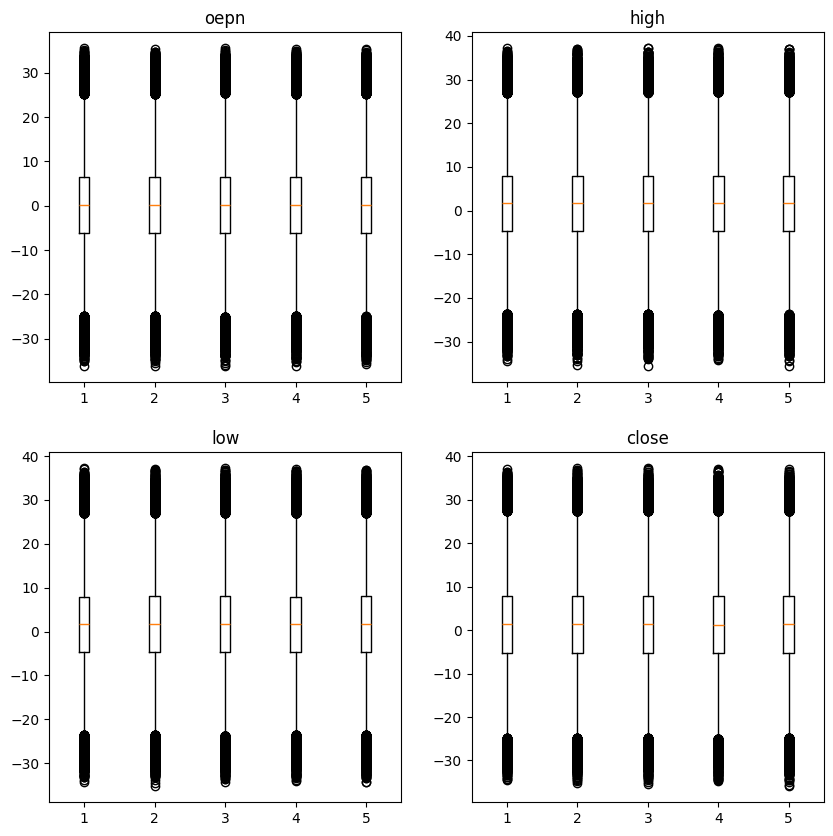

In [72]:
quant_1_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.25, axis=batch_dim), columns=columns)
quant_2_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.5, axis=batch_dim), columns=columns)
quant_3_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.75, axis=batch_dim), columns=columns)
min_org_df = pd.DataFrame(np.min(diff_array_org, axis=batch_dim), columns=columns)
max_org_df = pd.DataFrame(np.max(diff_array_org, axis=batch_dim), columns=columns)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for index in range(0, 5):
  axs[0,0].boxplot(get_feature_by_step(diff_array_org, index, 0), positions=[index+1])
  axs[0,1].boxplot(get_feature_by_step(diff_array_org, index, 1), positions=[index+1])
  axs[1,0].boxplot(get_feature_by_step(diff_array_org, index, 2), positions=[index+1])
  axs[1,1].boxplot(get_feature_by_step(diff_array_org, index, 3), positions=[index+1])

axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')
plt.plot()

In [73]:
validation_file_path = f'{base_folder}/{model_name}/{model_name}_v{model_version}_validation.csv'
validation_df = pd.concat([
    mean_df, var_df, quant_1_df, quant_2_df, quant_3_df, min_df, max_df,
    mean_org_df, var_org_df, quant_1_org_df, quant_2_org_df, quant_3_org_df, min_org_df, max_org_df,
    ],
    keys=[
        "mean", "var", "q1", "q2", "q3", "min", "max",
        "org_mean", "org_var", "org_q1", "org_q2", "org_q3", "org_min", "org_max"
        ],
    axis=1)
os.makedirs(os.path.dirname(validation_file_path), exist_ok=True)
validation_df.to_csv(validation_file_path)
if storage_handler is not None:
    destination_file_path = f'/{model_name}/{model_name}_v{model_version}_validation.csv'
    storage_handler.upload_file(validation_file_path, destination_file_path)

In [83]:
pre_ohlc[i,: 3].shape

(3, 4)

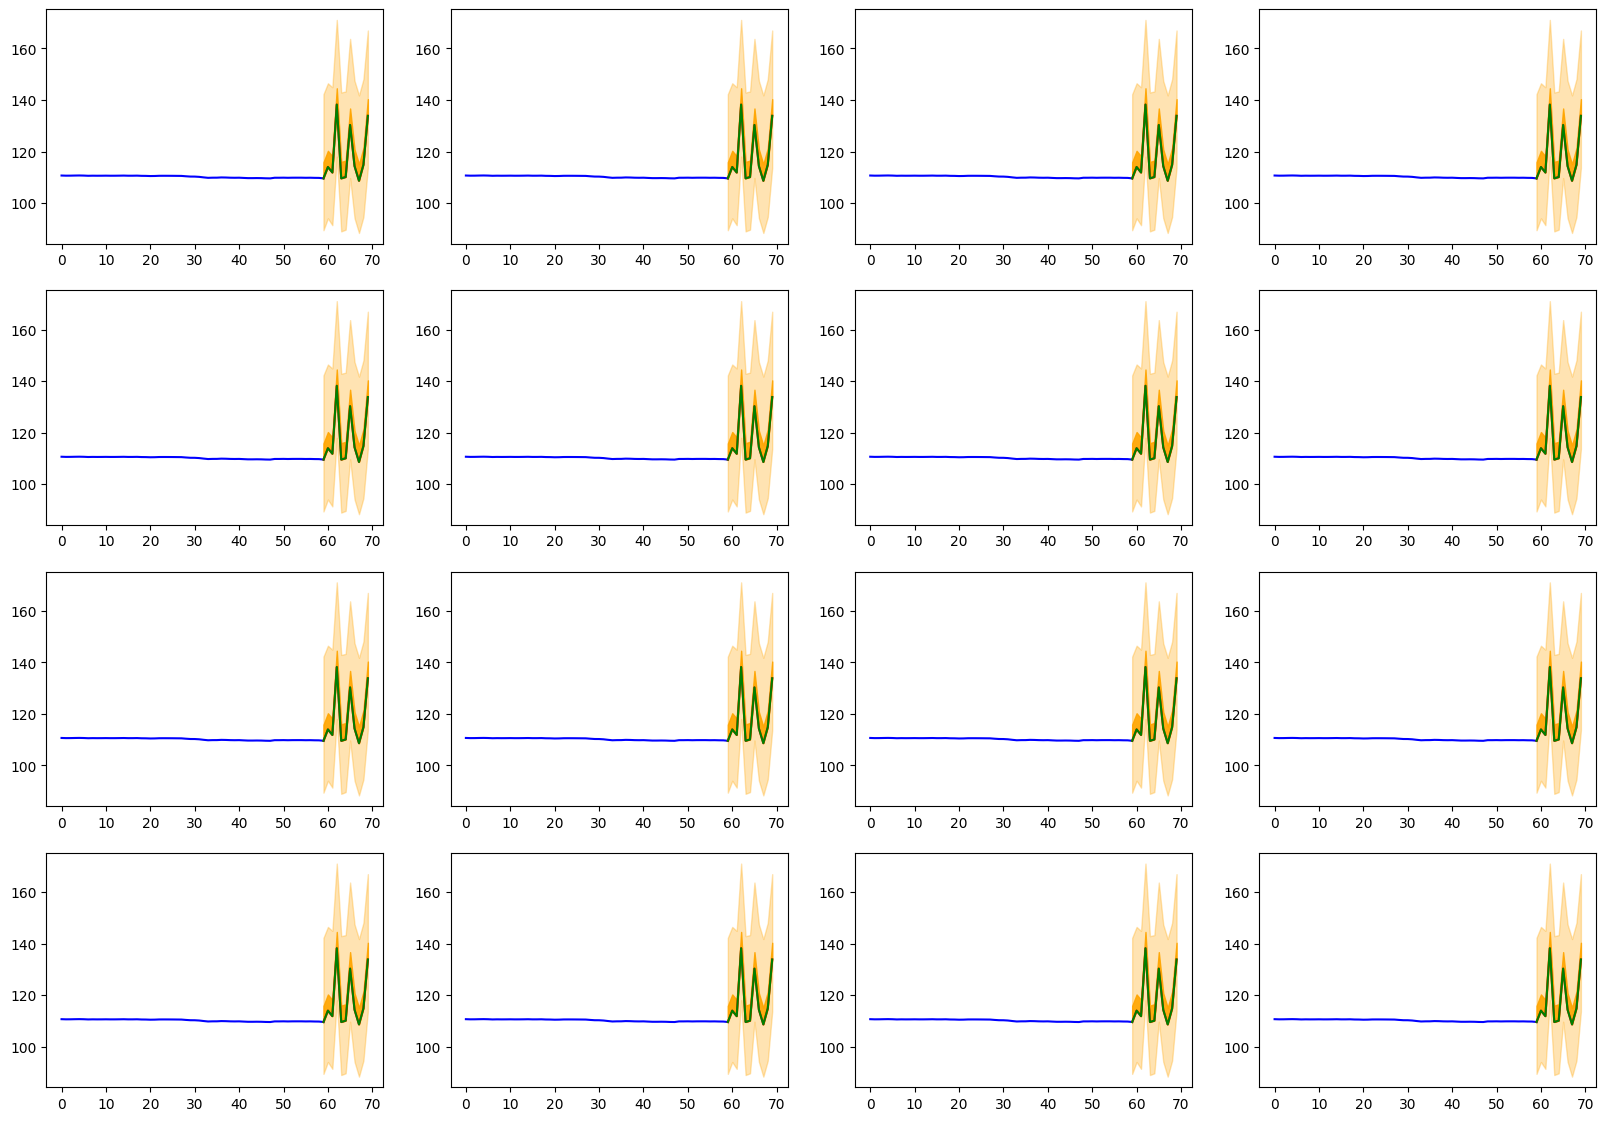

In [84]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(pre_ohlc[:, :, 3]-ans_ohlc[:, :, 3], axis=batch_dim)
close_var = np.var(pre_ohlc[:, :, 3]-ans_ohlc[:, :, 3], axis=batch_dim)

total_length = observation_length + prediction_length
x = np.arange(total_length)

for batch_index, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[3]].iloc[index: index + observation_length]
    if batch_first:
        pred_value = pre_ohlc[i,:, 3]
    else:
        pred_value = pre_ohlc[:, i, 3]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length -1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length -1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    if batch_first:
        ax.plot(x[observation_length-1:], pre_ohlc[i, :, 3], color="red")
    else:
        ax.plot(x[observation_length-1:], ans_ohlc[:, i, 3], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()